In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import pandas as pd
from rasterio.mask import mask
from shapely.geometry import Point

In [3]:
base = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES"

path_ndvi = os.path.join(base, "NDVI_2023_32618_30m.tif")
path_ndbi = os.path.join(base, "ndbi_reproyectado.tif")
path_lst  = os.path.join(base, "LST_2023_Reproyectado.tif")
path_stations = "/content/drive/MyDrive/..."


In [4]:
!pip install rasterio

Cargar NDVI, NDBI y LST, verificar alineación

In [5]:
import pandas as pd
pd.read_csv("/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/202_datos_meteorologicos_limpios.csv").head(10)


,codigo,fecha_hora,temperatura,calidad,latitud,longitud
0,202,2014-01-01 00:00:26,20.6,1,6.242238,-75.574031
1,202,2014-01-01 00:01:26,20.6,1,6.242238,-75.574031
2,202,2014-01-01 00:02:26,20.6,1,6.242238,-75.574031
3,202,2014-01-01 00:03:26,20.5,1,6.242238,-75.574031
4,202,2014-01-01 00:04:26,20.5,1,6.242238,-75.574031
5,202,2014-01-01 00:05:26,20.5,1,6.242238,-75.574031
6,202,2014-01-01 00:06:26,20.5,1,6.242238,-75.574031
7,202,2014-01-01 00:07:26,20.5,1,6.242238,-75.574031
8,202,2014-01-01 00:08:26,20.5,1,6.242238,-75.574031
9,202,2014-01-01 00:09:26,20.5,1,6.242238,-75.574031


In [6]:
import pandas as pd

path = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/202_datos_meteorologicos_limpios.csv"
df = pd.read_csv(path)
df.head(10)
df.columns


Index(['codigo', 'fecha_hora', 'temperatura', 'calidad', 'latitud',
       'longitud'],
      dtype='object')

In [7]:
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from rasterio.transform import rowcol


path_ndvi = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/ndvi_reproyectado.tif"
path_ndbi = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/ndbi_reproyectado.tif"
path_lst  = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/lst_reproyectada.tif"

def load_raster(path):
    src = rasterio.open(path)
    arr = src.read(1).astype("float32")
    return src, arr

src_ndvi, ndvi = load_raster(path_ndvi)
src_ndbi, ndbi = load_raster(path_ndbi)
src_lst,  lst  = load_raster(path_lst)

print("NDVI:", ndvi.shape, "NDBI:", ndbi.shape, "LST:", lst.shape)
print("CRS rasters:", src_ndvi.crs)

NDVI: (2294, 4209) NDBI: (2294, 4209) LST: (2294, 4209)
CRS rasters: EPSG:32618


In [8]:
path_202 = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/202_datos_meteorologicos_limpios.csv"
path_105 = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/105_datos_meteorologicos_limpios.csv"
path_82  = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/82_datos_meteorologicos_limpios.csv"

usecols = ["codigo", "fecha_hora", "temperatura", "calidad", "latitud", "longitud"]
dtypes  = {
    "codigo": "int16",
    "temperatura": "float32",
    "calidad": "int8",
    "latitud": "float64",
    "longitud": "float64"
}

df202 = pd.read_csv(path_202, usecols=usecols, dtype=dtypes)
df105 = pd.read_csv(path_105, usecols=usecols, dtype=dtypes)
df82  = pd.read_csv(path_82,  usecols=usecols, dtype=dtypes)

df_all = pd.concat([df202, df105, df82], ignore_index=True)
print(df_all.head())
print("Registros totales:", len(df_all))


   codigo           fecha_hora  temperatura  calidad   latitud   longitud
0     202  2014-01-01 00:00:26         20.6        1  6.242238 -75.574031
1     202  2014-01-01 00:01:26         20.6        1  6.242238 -75.574031
2     202  2014-01-01 00:02:26         20.6        1  6.242238 -75.574031
3     202  2014-01-01 00:03:26         20.5        1  6.242238 -75.574031
4     202  2014-01-01 00:04:26         20.5        1  6.242238 -75.574031
Registros totales: 16837911


In [9]:
stations = (df_all[["codigo", "latitud", "longitud"]]
            .drop_duplicates(subset="codigo")
            .set_index("codigo"))

stations


,latitud,longitud
codigo,,
202,6.242238,-75.574031
105,6.096280,-75.635360
82,6.434950,-75.326646


In [10]:
gdf_st = gpd.GeoDataFrame(
    stations.copy(),
    geometry=gpd.points_from_xy(stations.longitud, stations.latitud),
    crs="EPSG:4326"
)


gdf_st = gdf_st.to_crs(src_ndvi.crs)
print(gdf_st)


         latitud   longitud                       geometry
codigo                                                    
202     6.242238 -75.574031   POINT (436499.876 690016.79)
105     6.096280 -75.635360  POINT (429696.085 673888.985)
82      6.434950 -75.326646  POINT (463879.767 711296.816)


In [11]:
def extract_raster_value(src, array, point):
    row, col = rowcol(src.transform, point.x, point.y)
    if (0 <= row < array.shape[0]) and (0 <= col < array.shape[1]):
        return float(array[row, col])
    else:
        return np.nan

gdf_st["NDVI"] = gdf_st.geometry.apply(
    lambda p: extract_raster_value(src_ndvi, ndvi, p)
)
gdf_st["NDBI"] = gdf_st.geometry.apply(
    lambda p: extract_raster_value(src_ndbi, ndbi, p)
)
gdf_st["LST"] = gdf_st.geometry.apply(
    lambda p: extract_raster_value(src_lst, lst, p)
)

gdf_st


,latitud,longitud,geometry,NDVI,NDBI,LST
codigo,,,,,,
202,6.242238,-75.574031,POINT (436499.876 690016.79),3.0,2.0,41.615425
105,6.096280,-75.635360,POINT (429696.085 673888.985),3.0,1.0,35.609962
82,6.434950,-75.326646,POINT (463879.767 711296.816),3.0,1.0,36.444817


In [12]:
df_all["fecha_hora"] = pd.to_datetime(df_all["fecha_hora"])
df_all = df_all[df_all["calidad"] == 1]

temp_mean = (df_all.groupby("codigo")["temperatura"]
             .mean()
             .to_frame(name="T_media_aire"))

df_modelo = gdf_st.drop(columns="geometry").join(temp_mean)

df_modelo


,latitud,longitud,NDVI,NDBI,LST,T_media_aire
codigo,,,,,,
202,6.242238,-75.574031,3.0,2.0,41.615425,22.357101
105,6.096280,-75.635360,3.0,1.0,35.609962,19.124035
82,6.434950,-75.326646,3.0,1.0,36.444817,21.392302


Ajustar un modelo de regresión lineal:

In [13]:
print(gdf_st.columns.tolist())
print(gdf_st)


['latitud', 'longitud', 'geometry', 'NDVI', 'NDBI', 'LST']
         latitud   longitud                       geometry  NDVI  NDBI  \
codigo                                                                   
202     6.242238 -75.574031   POINT (436499.876 690016.79)   3.0   2.0   
105     6.096280 -75.635360  POINT (429696.085 673888.985)   3.0   1.0   
82      6.434950 -75.326646  POINT (463879.767 711296.816)   3.0   1.0   

              LST  
codigo             
202     41.615425  
105     35.609962  
82      36.444817  


In [14]:
import pandas as pd
import glob

base = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS"
files = glob.glob(base + "/*_datos_meteorologicos_limpios.csv")

temps = {}

for f in files:
    df = pd.read_csv(f)
    codigo = int(df["codigo"].iloc[0])
    t_media = df["temperatura"].mean()
    temps[codigo] = t_media

temps


{82: np.float64(14.594136185078845),
 105: np.float64(5.882891597000506),
 202: np.float64(14.727636814883615)}

In [15]:
df = pd.read_csv("/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/105_datos_meteorologicos_limpios.csv")

print(df["temperatura"].describe())
print(df["temperatura"].min(), df["temperatura"].max())


count    5.589873e+06
mean     5.882892e+00
std      1.152694e+02
min     -9.990000e+02
25%      1.650000e+01
50%      1.830000e+01
75%      2.140000e+01
max      3.500000e+01
Name: temperatura, dtype: float64
-999.0 35.0


In [16]:
df = pd.read_csv(path)

df["fecha_hora"] = pd.to_datetime(df["fecha_hora"], errors="coerce")


df_2023 = df[df["fecha_hora"].dt.year == 2023]


df_2023 = df_2023[df_2023["temperatura"] > -50]


df_2023 = df_2023[(df_2023["temperatura"] >= 5) & (df_2023["temperatura"] <= 40)]

t_media = df_2023["temperatura"].mean()
print("Temperatura 2023:", t_media)


Temperatura 2023: 22.58830874265991


In [17]:
df = pd.read_csv(path)


df["fecha_hora"] = pd.to_datetime(df["fecha_hora"], errors="coerce")


df_2023 = df[df["fecha_hora"].dt.year == 2023]


df_2023 = df_2023[df_2023["temperatura"] > -50]


df_2023 = df_2023[(df_2023["temperatura"] >= 5) & (df_2023["temperatura"] <= 40)]


tmed_por_estacion = df_2023.groupby("codigo")["temperatura"].mean().to_dict()

tmed_por_estacion


{202: 22.5883087426599}

In [18]:
import pandas as pd
import numpy as np


base_path = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS"


archivos_estaciones = {
    82:  "82_datos_meteorologicos_limpios.csv",
    105: "105_datos_meteorologicos_limpios.csv",
    202: "202_datos_meteorologicos_limpios.csv",
}

def temp_media_2023(ruta_csv):
    """Lee un CSV de una estación, filtra 2023 y devuelve la T media."""
    df = pd.read_csv(ruta_csv)


    df["fecha_hora"] = pd.to_datetime(df["fecha_hora"], errors="coerce")


    df_2023 = df[df["fecha_hora"].dt.year == 2023].copy()


    df_2023["temperatura"] = df_2023["temperatura"].replace(-999, np.nan)


    return df_2023["temperatura"].mean()


t_media_dict = {}

for cod, fname in archivos_estaciones.items():
    ruta = f"{base_path}/{fname}"
    t_media_dict[cod] = temp_media_2023(ruta)

t_media_dict


{82: np.float64(21.60139875986652),
 105: np.float64(19.330747824365584),
 202: np.float64(22.588308742659905)}

In [19]:
t_media_dict = {
    82: 21.60139875986652,
    105: 19.330747824365584,
    202: 22.588308742659905
}

gdf_st["T_media_aire"] = gdf_st.index.map(t_media_dict)
gdf_st


,latitud,longitud,geometry,NDVI,NDBI,LST,T_media_aire
codigo,,,,,,,
202,6.242238,-75.574031,POINT (436499.876 690016.79),3.0,2.0,41.615425,22.588309
105,6.096280,-75.635360,POINT (429696.085 673888.985),3.0,1.0,35.609962,19.330748
82,6.434950,-75.326646,POINT (463879.767 711296.816),3.0,1.0,36.444817,21.601399


# Indicador de intensidad de UHI (ΔT)

La idea es generar un indicador térmico comparable que combine:

*   Temperatura superficial (LST) → satelital
*   Temperatura del aire → estaciones SIATA

Para medir la diferencia entre lo que “siente el aire” vs. lo que está calentando la superficie urbana.

**Cálculo del ΔT por estación**

In [20]:

gdf_st["DeltaT"] = gdf_st["LST"] - gdf_st["T_media_aire"]

print(gdf_st[["NDVI", "NDBI", "LST", "T_media_aire", "DeltaT"]])


        NDVI  NDBI        LST  T_media_aire     DeltaT
codigo                                                
202      3.0   2.0  41.615425     22.588309  19.027116
105      3.0   1.0  35.609962     19.330748  16.279215
82       3.0   1.0  36.444817     21.601399  14.843418


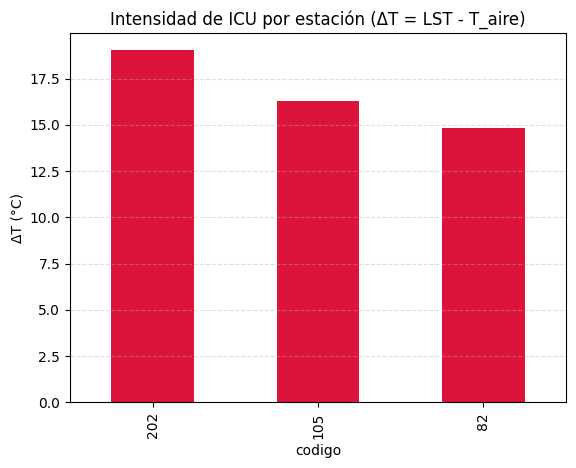

In [21]:
import matplotlib.pyplot as plt

gdf_st["DeltaT"].plot(kind="bar", color="crimson")
plt.xticks(range(len(gdf_st)), gdf_st.index.astype(str))
plt.title("Intensidad de ICU por estación (ΔT = LST - T_aire)")
plt.ylabel("ΔT (°C)")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


# Análisis exploratorio: boxplots y heatmaps


In [22]:
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

base = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/"

path_ndvi = base + "NDVI_2023_32618_30m.tif"
path_ndbi = base + "ndbi_reproyectado.tif"
path_lst  = base + "LST_2023_Reproyectado.tif"


In [23]:
import rasterio
import numpy as np
import pandas as pd

path_ndvi = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/NDVI_2023_32618_30m.tif"
path_ndbi = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/ndbi_reproyectado.tif"
path_lst  = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/LST_2023_Reproyectado.tif"

def load_band(path):
    src = rasterio.open(path)
    arr = src.read(1).astype("float32")
    return src, arr

src_ndvi, ndvi = load_band(path_ndvi)
src_ndbi, ndbi = load_band(path_ndbi)
src_lst,  lst  = load_band(path_lst)

print("NDVI:", ndvi.shape, "NDBI:", ndbi.shape, "LST:", lst.shape)


nodata_ndvi = src_ndvi.nodata
if nodata_ndvi is not None:
    ndvi[ndvi == nodata_ndvi] = np.nan

nodata_ndbi = src_ndbi.nodata
if nodata_ndbi is None:
    nodata_ndbi = -9999
ndbi[ndbi <= -1000] = np.nan


nodata_lst = src_lst.nodata
if nodata_lst is not None:
    lst[lst == nodata_lst] = np.nan
lst[lst < -50] = np.nan


mask_valid = (~np.isnan(ndvi)) & (~np.isnan(ndbi)) & (~np.isnan(lst))

print("Píxeles válidos:", mask_valid.sum())


NDVI: (2294, 4209) NDBI: (2294, 4209) LST: (2294, 4209)
Píxeles válidos: 1217573


In [24]:
ndvi_valid = ndvi[mask_valid]
ndbi_valid = ndbi[mask_valid]
lst_valid  = lst[mask_valid]

n = 200_000
n_tot = ndvi_valid.size
n_sample = min(n, n_tot)

idx = np.random.choice(n_tot, size=n_sample, replace=False)

df_sample = pd.DataFrame({
    "NDVI": ndvi_valid[idx],
    "NDBI": ndbi_valid[idx],
    "LST":  lst_valid[idx]
})


df_sample = df_sample[df_sample["NDBI"] > -100]

df_sample.describe()


,NDVI,NDBI,LST
count,200000.000000,200000.000000,200000.000000
mean,0.290500,1.115475,18.906324
std,0.098343,0.333037,7.916547
min,0.048163,1.000000,-20.050783
25%,0.211827,1.000000,14.413113
50%,0.284430,1.000000,18.439541
75%,0.369231,1.000000,23.150426
max,0.591657,3.000000,45.417973


In [25]:
!pip install rasterio

In [26]:
import os
from glob import glob

base_datos = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS"
base_sat   = os.path.join(base_datos, "DATOS_SATELITALES")

print("base_datos:", base_datos)
print("base_sat:", base_sat)

print("\nContenido de DATOS_SATELITALES:")
for f in os.listdir(base_sat):
    print("  ", f)


print("\nArchivos que parecen NDVI:")
for f in glob(os.path.join(base_sat, "*NDVI*2023*.tif")):
    print("  ", f)


base_datos: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS
base_sat: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES

Contenido de DATOS_SATELITALES:
   Municipios_ValledeAburra.prj
   Municipios_ValledeAburra.dbf
   Municipios_ValledeAburra.cpg
   Municipios_ValledeAburra.shx
   Municipios_ValledeAburra.qmd
   Municipios_ValledeAburra.shp
   ValleAburraSimplificado.qmd
   ValleAburraSimplificado.dbf
   ValleAburraSimplificado.prj
   ValleAburraSimplificado.cpg
   ValleAburraSimplificado.shx
   ValleAburraSimplificado.shp
   NDVI_2023.tif
   NDVI_2023.tif.aux.xml
   Landsat8_2023-03-22.tif
   Landsat8_2016-05-21.tif
   Landsat8_2017-12-18.tif
   Landsat8_2023-02-02.tif
   Landsat8_2020-01-09(1).tif
   Landsat8_2019-07-17.tif
   Landsat8_2018-07-14.tif
   Landsat8_2022-07-09.tif
   Landsat8_2020-02-10(1).tif
   Landsat8_2020-01-09.tif
   Landsat8_2020-02-10.tif
   Landsat8_2020-02-10(1).ti

In [27]:
import rasterio
import numpy as np
import pandas as pd

base = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES"

path_ndvi = f"{base}/NDVI_2023_32618_30m.tif"
path_ndbi = f"{base}/ndbi_reproyectado.tif"
path_lst  = f"{base}/LST_2023_Reproyectado.tif"

with rasterio.open(path_ndvi) as src:
    ndvi = src.read(1).astype(float)
    ndvi_nodata = src.nodata

with rasterio.open(path_ndbi) as src:
    ndbi = src.read(1).astype(float)
    ndbi_nodata = src.nodata

with rasterio.open(path_lst) as src:
    lst = src.read(1).astype(float)
    lst_nodata = src.nodata

print("Shapes:", ndvi.shape, ndbi.shape, lst.shape)


mask_valid = (
    (~np.isnan(ndvi)) & (ndvi != ndvi_nodata) &
    (~np.isnan(ndbi)) & (ndbi != ndbi_nodata) &
    (~np.isnan(lst)) & (lst != lst_nodata)
)

ndbi = np.where(ndbi == -9999, np.nan, ndbi)
mask_valid = mask_valid & (~np.isnan(ndbi))

ndvi_flat = ndvi[mask_valid]
ndbi_flat = ndbi[mask_valid]
lst_flat  = lst[mask_valid]

df_pixels = pd.DataFrame({
    "NDVI": ndvi_flat,
    "NDBI": ndbi_flat,
    "LST": lst_flat
})

print("df_pixels creado con:", df_pixels.shape, "filas")
df_pixels.head()


Shapes: (2294, 4209) (2294, 4209) (2294, 4209)
df_pixels creado con: (1217573, 3) filas


,NDVI,NDBI,LST
0,0.180348,1.0,2.088416
1,0.194356,1.0,2.906007
2,0.211636,1.0,3.154839
3,0.212140,1.0,3.288825
4,0.196947,1.0,2.603854


In [28]:
df_pixels.describe()


,NDVI,NDBI,LST
count,1.217573e+06,1.217573e+06,1.217573e+06
mean,2.905421e-01,1.115636e+00,1.889792e+01
std,9.851689e-02,3.329664e-01,7.929207e+00
min,3.841887e-02,1.000000e+00,-2.141970e+01
25%,2.115401e-01,1.000000e+00,1.440901e+01
50%,2.846054e-01,1.000000e+00,1.845116e+01
75%,3.696149e-01,1.000000e+00,2.315983e+01
max,6.228919e-01,3.000000e+00,4.615968e+01


CATEGORIZACIÓN DE NDVI Y NDBI

In [29]:

def categorize_ndvi(x):
    if x < 0.15:
        return "Muy baja"
    elif x < 0.30:
        return "Baja"
    elif x < 0.45:
        return "Media"
    else:
        return "Alta"

df_pixels["NDVI_cat"] = df_pixels["NDVI"].apply(categorize_ndvi)


Categorías NDBI (urbanización)

In [30]:
df_pixels["NDBI_cat"] = df_pixels["NDBI"].map({
    1: "Baja",
    2: "Media",
    3: "Alta"
})


BOXPLOTS NDVI → LST

/tmp/ipython-input-1741488952.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


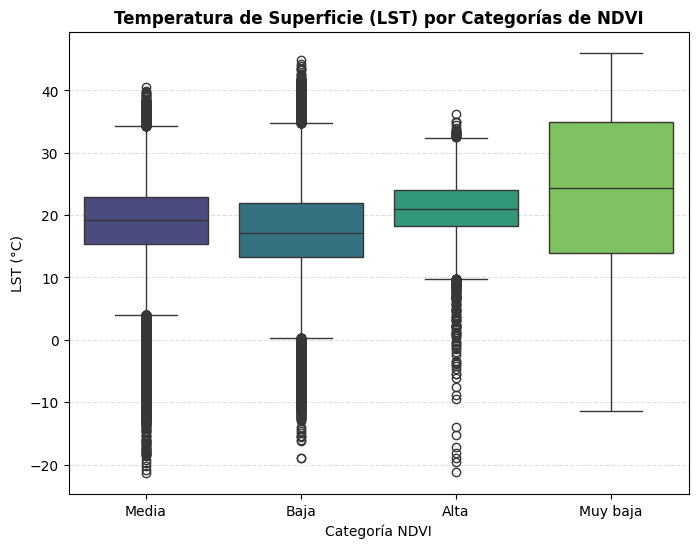

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.boxplot(
    data=df_pixels.sample(200000),
    x="NDVI_cat", y="LST",
    palette="viridis"
)
plt.title("Temperatura de Superficie (LST) por Categorías de NDVI", fontweight="bold")
plt.xlabel("Categoría NDVI")
plt.ylabel("LST (°C)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.savefig("boxplot_NDVI_LST.png", dpi=300, bbox_inches="tight")
plt.show()


BOXPLOTS NDBI → LST

/tmp/ipython-input-799116831.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


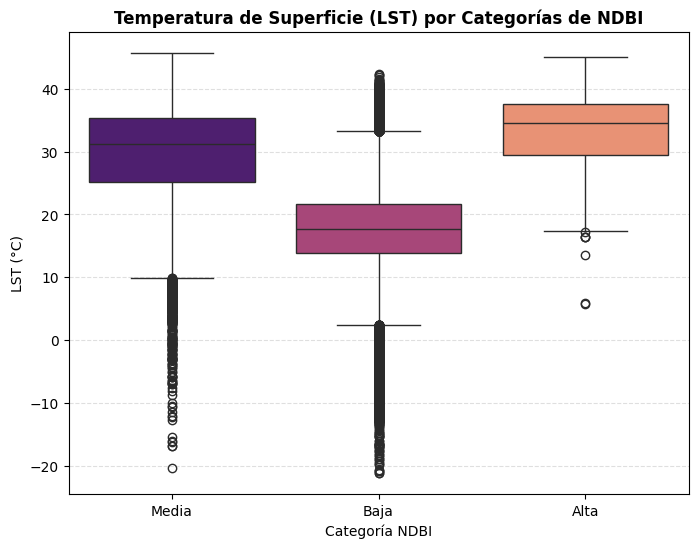

In [32]:
plt.figure(figsize=(8,6))
sns.boxplot(
    data=df_pixels.sample(200000),
    x="NDBI_cat", y="LST",
    palette="magma"
)
plt.title("Temperatura de Superficie (LST) por Categorías de NDBI", fontweight="bold")
plt.xlabel("Categoría NDBI")
plt.ylabel("LST (°C)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.savefig("boxplot_NDBI_LST.png", dpi=300, bbox_inches="tight")
plt.show()


HEATMAP NDVI–NDBI → LST (matriz 2D)

In [33]:

df_pixels["NDVI_bin"] = pd.cut(
    df_pixels["NDVI"],
    bins=[0,0.15,0.30,0.45,1],
    labels=["0–0.15","0.15–0.30","0.30–0.45",">0.45"]
)


In [34]:
heat = df_pixels.pivot_table(
    index="NDVI_bin",
    columns="NDBI_cat",
    values="LST",
    aggfunc="mean"
)
heat


/tmp/ipython-input-1050274157.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heat = df_pixels.pivot_table(


NDBI_cat,Alta,Baja,Media
NDVI_bin,,,
0–0.15,34.355470,14.879737,33.074489
0.15–0.30,31.696231,16.174897,28.612657
0.30–0.45,25.395822,18.725882,24.301843
>0.45,NaN,20.849103,20.965639


In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



bins_ndvi   = [0.0, 0.21, 0.37, 1.0]
labels_3    = ['Baja', 'Media', 'Alta']

df_pixels['NDVI_cat'] = pd.cut(
    df_pixels['NDVI'],
    bins=bins_ndvi,
    labels=labels_3,
    include_lowest=True
)


map_ndbi = {1: 'Baja', 2: 'Media', 3: 'Alta'}
df_pixels['NDBI_cat'] = df_pixels['NDBI'].map(map_ndbi)


cat_type = pd.CategoricalDtype(categories=labels_3, ordered=True)
df_pixels['NDVI_cat'] = df_pixels['NDVI_cat'].astype(cat_type)
df_pixels['NDBI_cat'] = df_pixels['NDBI_cat'].astype(cat_type)


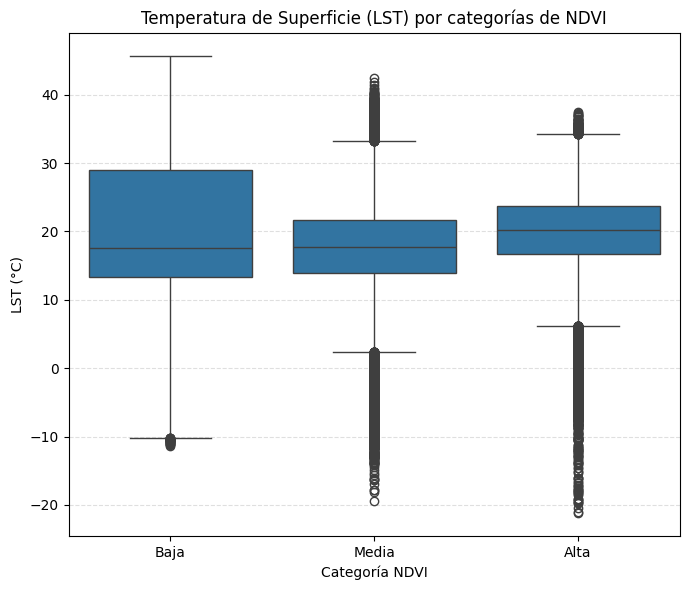

In [36]:

plt.figure(figsize=(7, 6))
sns.boxplot(
    data=df_pixels.sample(200000, random_state=42),
    x='NDVI_cat',
    y='LST',
    order=labels_3
)
plt.xlabel('Categoría NDVI')
plt.ylabel('LST (°C)')
plt.title('Temperatura de Superficie (LST) por categorías de NDVI')

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('boxplot_LST_por_NDVI.png', dpi=300, bbox_inches='tight')
plt.show()


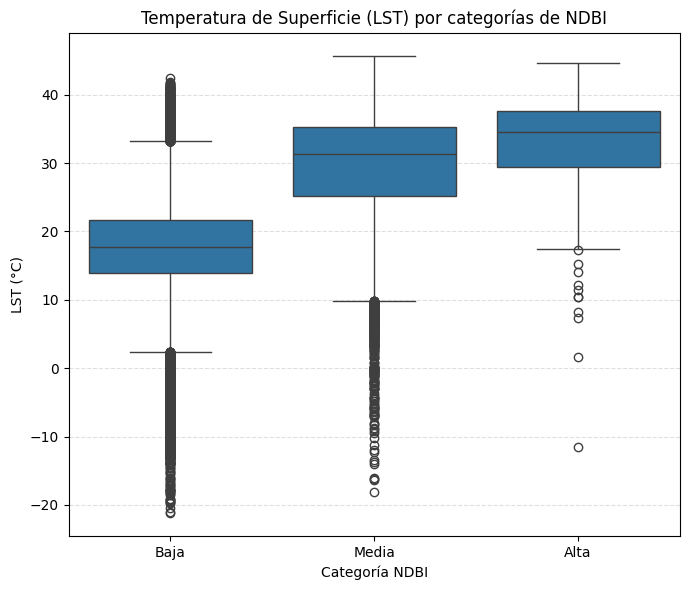

In [37]:

plt.figure(figsize=(7, 6))
sns.boxplot(
    data=df_pixels.sample(200000, random_state=42),
    x='NDBI_cat',
    y='LST',
    order=labels_3
)
plt.xlabel('Categoría NDBI')
plt.ylabel('LST (°C)')
plt.title('Temperatura de Superficie (LST) por categorías de NDBI')

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('boxplot_LST_por_NDBI.png', dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipython-input-2683428297.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['NDVI_cat', 'NDBI_cat'])['LST']


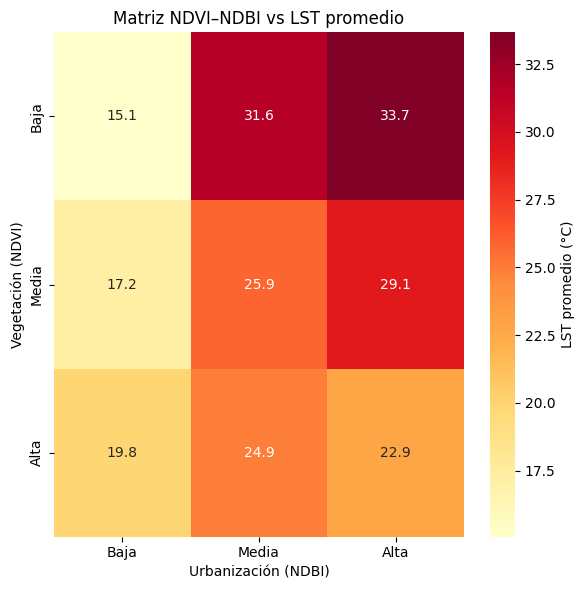

In [38]:

tabla = (
    df_pixels
    .groupby(['NDVI_cat', 'NDBI_cat'])['LST']
    .mean()
    .unstack()
)


tabla = tabla.loc[labels_3, labels_3]

plt.figure(figsize=(6, 6))
sns.heatmap(
    tabla,
    annot=True,
    fmt='.1f',
    cmap='YlOrRd',
    cbar_kws={'label': 'LST promedio (°C)'}
)
plt.xlabel('Urbanización (NDBI)')
plt.ylabel('Vegetación (NDVI)')
plt.title('Matriz NDVI–NDBI vs LST promedio')

plt.tight_layout()
plt.savefig('heatmap_NDVI_NDBI_LST.png', dpi=300, bbox_inches='tight')
plt.show()


In [39]:
palette_pastel = {
    'Baja':   '#a8e6a1',   # verde pastel
    'Media':  '#ffe8a1',   # amarillo pastel
    'Alta':   '#ffb3b3'    # rojo pastel
}


/tmp/ipython-input-3657062211.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


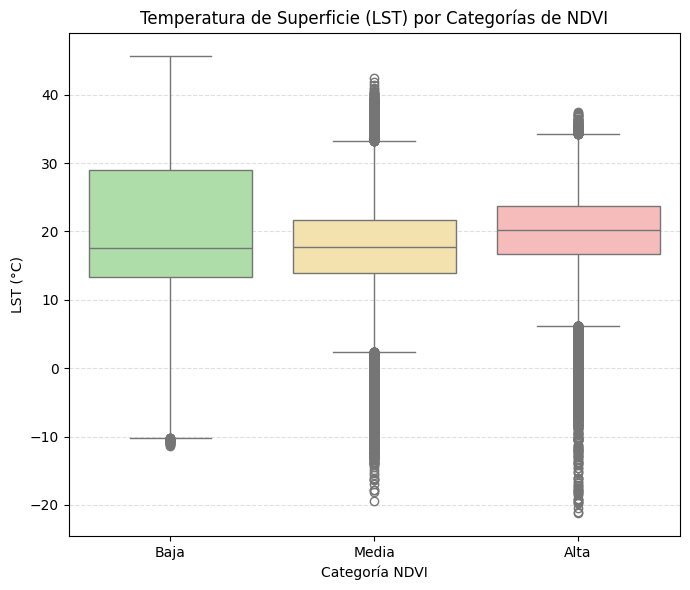

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

labels_3 = ['Baja', 'Media', 'Alta']

plt.figure(figsize=(7,6))
sns.boxplot(
    data=df_pixels.sample(200000, random_state=42),
    x='NDVI_cat',
    y='LST',
    order=labels_3,
    palette=palette_pastel
)

plt.xlabel('Categoría NDVI')
plt.ylabel('LST (°C)')
plt.title('Temperatura de Superficie (LST) por Categorías de NDVI')
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig("boxplot_LST_NDVI_pastel.png", dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipython-input-3865418183.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


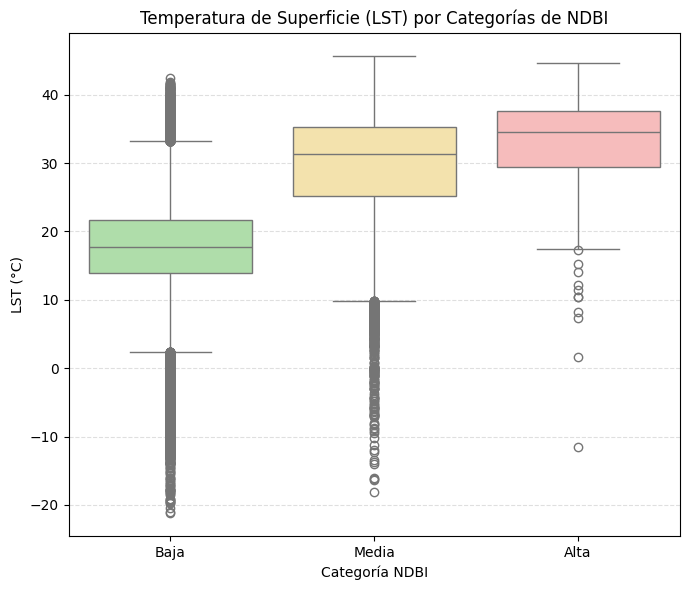

In [41]:
plt.figure(figsize=(7,6))
sns.boxplot(
    data=df_pixels.sample(200000, random_state=42),
    x='NDBI_cat',
    y='LST',
    order=labels_3,
    palette=palette_pastel
)

plt.xlabel('Categoría NDBI')
plt.ylabel('LST (°C)')
plt.title('Temperatura de Superficie (LST) por Categorías de NDBI')
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig("boxplot_LST_NDBI_pastel.png", dpi=300, bbox_inches='tight')
plt.show()


In [42]:
from matplotlib.colors import LinearSegmentedColormap

pastel_colors = [
    "#fff5cc",
    "#ffd6e0",
    "#e0c3fc",
    "#c7eaff"
]

cmap_pastel = LinearSegmentedColormap.from_list("pastel_heatmap", pastel_colors)


/tmp/ipython-input-1168323499.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heat_data = df_pixels.pivot_table(


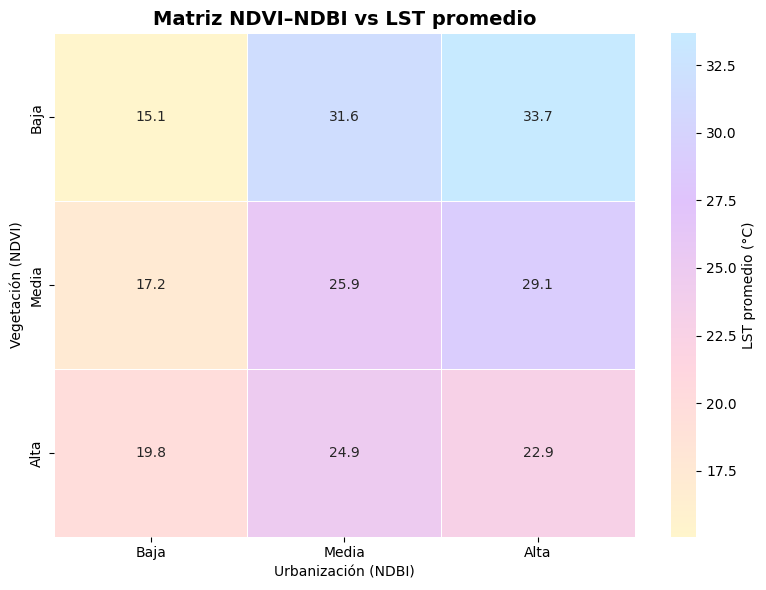

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

heat_data = df_pixels.pivot_table(
    values='LST',
    index='NDVI_cat',
    columns='NDBI_cat',
    aggfunc='mean'
)

plt.figure(figsize=(8,6))
sns.heatmap(
    heat_data,
    annot=True,
    fmt=".1f",
    cmap=cmap_pastel,
    linewidths=.5,
    cbar_kws={'label': 'LST promedio (°C)'},
    annot_kws={"size": 10}
)

plt.title("Matriz NDVI–NDBI vs LST promedio", fontsize=14, fontweight='bold')
plt.xlabel("Urbanización (NDBI)")
plt.ylabel("Vegetación (NDVI)")

plt.tight_layout()
plt.savefig("heatmap_LST_pastel.png", dpi=300, bbox_inches='tight')
plt.show()


# Modelos de regresión cobertura–temperatura

In [44]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

df_model = df_pixels.sample(100_000, random_state=42)

X1 = df_model[['NDVI', 'NDBI']]
y = df_model['LST']

X1_const = sm.add_constant(X1)
model1 = sm.OLS(y, X1_const).fit()

print("\n=== MODELO 1: NDVI + NDBI ===")
print(model1.summary())

df_model['NDVIxNDBI'] = df_model['NDVI'] * df_model['NDBI']

X2 = df_model[['NDVI', 'NDBI', 'NDVIxNDBI']]
X2_const = sm.add_constant(X2)
model2 = sm.OLS(y, X2_const).fit()

print("\n=== MODELO 2: NDVI + NDBI + Interacción ===")
print(model2.summary())



=== MODELO 1: NDVI + NDBI ===
                            OLS Regression Results                            
Dep. Variable:                    LST   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                 1.804e+04
Date:                Tue, 09 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:38:37   Log-Likelihood:            -3.3354e+05
No. Observations:              100000   AIC:                         6.671e+05
Df Residuals:                   99997   BIC:                         6.671e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0093

In [45]:
import statsmodels.formula.api as smf

df_pixels["NDVIXNDBI"] = df_pixels["NDVI"] * df_pixels["NDBI"]
modelo2 = smf.ols("LST ~ NDVI + NDBI + NDVIXNDBI", data=df_pixels).fit()

latex_tabla = modelo2.summary2().tables[1].to_latex(float_format="%.3f")
print(latex_tabla)


\begin{tabular}{lrrrrrr}
\toprule
 & Coef. & Std.Err. & t & P>|t| & [0.025 & 0.975] \\
\midrule
Intercept & -10.715 & 0.065 & -164.523 & 0.000 & -10.842 & -10.587 \\
NDVI & 69.293 & 0.287 & 241.511 & 0.000 & 68.731 & 69.856 \\
NDBI & 23.009 & 0.054 & 423.122 & 0.000 & 22.903 & 23.116 \\
NDVIXNDBI & -51.821 & 0.264 & -196.471 & 0.000 & -52.338 & -51.304 \\
\bottomrule
\end{tabular}



In [46]:
import numpy as np
import rasterio
from rasterio.transform import xy

with rasterio.open(path_ndvi) as src_ref:
    transform = src_ref.transform
    nrows, ncols = src_ref.height, src_ref.width
    profile_ref = src_ref.profile

print(nrows, ncols)

rows = np.arange(nrows)
cols = np.arange(ncols)
cols_grid, rows_grid = np.meshgrid(cols, rows)

xs, ys = rasterio.transform.xy(
    transform,
    rows_grid,
    cols_grid,
    offset="center"
)
xs = np.array(xs)
ys = np.array(ys)

x_flat = xs.ravel()
y_flat = ys.ravel()

coords = np.vstack([gdf_st.geometry.x.values,
                    gdf_st.geometry.y.values]).T
temps  = gdf_st["T_media_aire"].values


dx = x_flat[:, None] - coords[None, :, 0]
dy = y_flat[:, None] - coords[None, :, 1]
dist = np.sqrt(dx**2 + dy**2)


dist[dist == 0] = 1e-6

p = 2.0
weights = 1.0 / (dist**p)
weights /= weights.sum(axis=1, keepdims=True)

Taire_flat = (weights * temps[None, :]).sum(axis=1)
Taire_grid = Taire_flat.reshape(nrows, ncols)

mask_valid = ~np.isnan(lst)
Taire_grid[~mask_valid] = np.nan


2294 4209


In [47]:
import numpy as np
import pandas as pd

ndvi_flat = ndvi.ravel()
ndbi_flat = ndbi.ravel()
lst_flat  = lst.ravel()


mask = ~np.isnan(ndvi_flat) & ~np.isnan(ndbi_flat) & ~np.isnan(lst_flat)


df_reg = pd.DataFrame({
    "NDVI": ndvi_flat[mask],
    "NDBI": ndbi_flat[mask],
    "LST":  lst_flat[mask]
})


df_reg["NDVIxNDBI"] = df_reg["NDVI"] * df_reg["NDBI"]


In [48]:
import statsmodels.api as sm

X = df_reg[["NDVI", "NDBI", "NDVIxNDBI"]]
X = sm.add_constant(X)
y = df_reg["LST"]

result2 = sm.OLS(y, X).fit()
print(result2.summary())


                            OLS Regression Results                            
Dep. Variable:                    LST   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                 1.614e+05
Date:                Tue, 09 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:38:42   Log-Likelihood:            -4.0449e+06
No. Observations:             1217573   AIC:                         8.090e+06
Df Residuals:                 1217569   BIC:                         8.090e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.7145      0.065   -164.523      0.0

In [50]:
import pandas as pd
import statsmodels.api as sm

# Aplanar rasters
ndvi_flat = ndvi.ravel()
ndbi_flat = ndbi.ravel()
lst_flat  = lst.ravel()

mask_reg = ~np.isnan(ndvi_flat) & ~np.isnan(ndbi_flat) & ~np.isnan(lst_flat)

X_full = pd.DataFrame({
    "NDVI": ndvi_flat[mask_reg],
    "NDBI": ndbi_flat[mask_reg]
})
X_full["NDVIxNDBI"] = X_full["NDVI"] * X_full["NDBI"]
X_full = sm.add_constant(X_full)

LST_pred_vec = np.full(ndvi_flat.shape, np.nan)
LST_pred_vec[mask_reg] = result2.predict(X_full)

LST_pred_raster = LST_pred_vec.reshape(nrows, ncols)


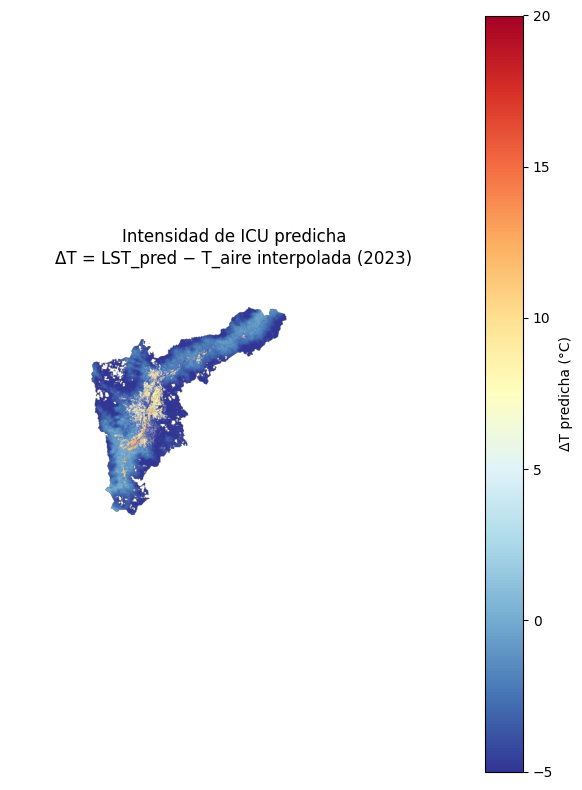

GeoTIFF guardado en: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/deltaT_pred_2023.tif
PNG para la tesis: deltaT_pred_2023.png


In [51]:
import matplotlib.pyplot as plt

deltaT_raster = LST_pred_raster - Taire_grid

plt.figure(figsize=(6, 8))
im = plt.imshow(deltaT_raster,
                cmap="RdYlBu_r",
                vmin=-5, vmax=20)
cbar = plt.colorbar(im, label="ΔT predicha (°C)")
plt.title("Intensidad de ICU predicha\nΔT = LST_pred − T_aire interpolada (2023)")
plt.axis("off")
plt.tight_layout()
plt.savefig("deltaT_pred_2023.png", dpi=300)
plt.show()

delta_profile = profile_ref.copy()
delta_profile.update(
    dtype="float32",
    count=1,
    nodata=-9999.0
)

deltaT_to_save = deltaT_raster.copy()
deltaT_to_save[np.isnan(deltaT_to_save)] = -9999.0

out_tif = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/deltaT_pred_2023.tif"

with rasterio.open(out_tif, "w", **delta_profile) as dst:
    dst.write(deltaT_to_save.astype("float32"), 1)

print("GeoTIFF guardado en:", out_tif)
print("PNG para la tesis: deltaT_pred_2023.png")


In [52]:
xmin = transform[2]
xmax = xmin + transform[0] * ncols
ymax = transform[5]
ymin = ymax + transform[4] * nrows

extent = (xmin, xmax, ymin, ymax)
extent


(397507.1537, 523777.1537, 661245.1386, 730065.1386)

/tmp/ipython-input-4122453611.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


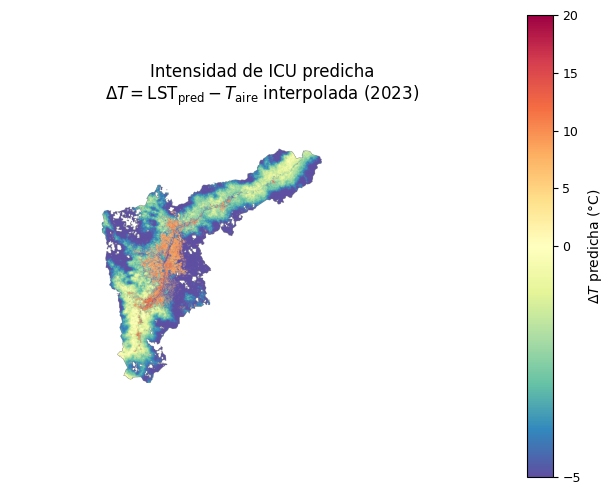

In [53]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.gridspec as gridspec
import numpy as np

vmin, vmax = -5, 20
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

fig = plt.figure(figsize=(7, 6))
gs = gridspec.GridSpec(
    1, 2,
    width_ratios=[20, 1],
    wspace=0.05
)

ax  = fig.add_subplot(gs[0, 0])
cax = fig.add_subplot(gs[0, 1])

im = ax.imshow(
    deltaT_raster,
    cmap="Spectral_r",
    norm=norm,
    extent=extent,
    origin="upper"
)

ax.set_axis_off()
ax.set_title(
    "Intensidad de ICU predicha\n"
    r"$\Delta T = \mathrm{LST_{pred}} - T_{\mathrm{aire}}$ interpolada (2023)",
    fontsize=12
)

cb = fig.colorbar(im, cax=cax)
cb.set_label(r"$\Delta T$ predicha (°C)", fontsize=10)
cb.ax.tick_params(labelsize=9)

plt.tight_layout()


plt.savefig(
    "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/"
    "TRABAJO DE GRADO/DATOS/GRAFICAS/mapa_deltaT_predicha_2023.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


# Mapa de zonas críticas (NDVI bajo + NDBI alto + LST alta)

In [54]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

base_sat = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES"

path_ndvi = f"{base_sat}/NDVI_2023_32618_30m.tif"
path_ndbi = f"{base_sat}/ndbi_reproyectado.tif"
path_lst  = f"{base_sat}/LST_2023_Reproyectado.tif"

def load_raster(path):
    src = rasterio.open(path)
    arr = src.read(1).astype(float)
    nodata = src.nodata
    if nodata is not None:
        arr[arr == nodata] = np.nan
    return src, arr

src_ndvi, ndvi = load_raster(path_ndvi)
src_ndbi, ndbi = load_raster(path_ndbi)
src_lst,  lst  = load_raster(path_lst)

print("Shapes NDVI / NDBI / LST:", ndvi.shape, ndbi.shape, lst.shape)


mask_valid = ~np.isnan(ndvi) & ~np.isnan(ndbi) & ~np.isnan(lst)


Shapes NDVI / NDBI / LST: (2294, 4209) (2294, 4209) (2294, 4209)


In [55]:

ndvi_valid = ndvi[mask_valid]
ndbi_valid = ndbi[mask_valid]
lst_valid  = lst[mask_valid]

p_ndvi_25 = np.nanpercentile(ndvi_valid, 25)
p_ndbi_75 = np.nanpercentile(ndbi_valid, 75)
p_lst_75  = np.nanpercentile(lst_valid, 75)

print("Umbral NDVI bajo (p25):", p_ndvi_25)
print("Umbral NDBI alto (p75):", p_ndbi_75)
print("Umbral LST alta (p75):", p_lst_75)


cond_ndvi_bajo = ndvi <= p_ndvi_25
cond_ndbi_alto = ndbi >= p_ndbi_75
cond_lst_alta  = lst  >= p_lst_75


Umbral NDVI bajo (p25): 0.21154014766216278
Umbral NDBI alto (p75): 1.0
Umbral LST alta (p75): 23.159825960000006


In [56]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

base_sat = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES"

path_ndvi = f"{base_sat}/NDVI_2023_32618_30m.tif"
path_ndbi = f"{base_sat}/ndbi_reproyectado.tif"
path_lst  = f"{base_sat}/LST_2023_Reproyectado.tif"

def load_raster(path):
    src = rasterio.open(path)
    arr = src.read(1).astype(float)
    nodata = src.nodata
    if nodata is not None:
        arr[arr == nodata] = np.nan
    return src, arr

src_ndvi, ndvi = load_raster(path_ndvi)
src_ndbi, ndbi = load_raster(path_ndbi)
src_lst,  lst  = load_raster(path_lst)

print("Shapes NDVI / NDBI / LST:", ndvi.shape, ndbi.shape, lst.shape)


mask_valid = ~np.isnan(ndvi) & ~np.isnan(ndbi) & ~np.isnan(lst)


Shapes NDVI / NDBI / LST: (2294, 4209) (2294, 4209) (2294, 4209)


In [57]:

zonas_criticas = np.zeros_like(ndvi, dtype=np.uint8)
zonas_criticas[mask_valid & cond_ndvi_bajo & cond_ndbi_alto & cond_lst_alta] = 1

print("N° píxeles críticos:", int(zonas_criticas.sum()))


N° píxeles críticos: 102443


In [58]:
out_crit_tif = f"{base_sat}/zonas_criticas_2023.tif"

profile = src_ndvi.profile.copy()
profile.update(
    dtype=rasterio.uint8,
    count=1,
    nodata=0
)

with rasterio.open(out_crit_tif, "w", **profile) as dst:
    dst.write(zonas_criticas, 1)

print("Raster de zonas críticas guardado en:", out_crit_tif)


Raster de zonas críticas guardado en: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/zonas_criticas_2023.tif


/tmp/ipython-input-600195942.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


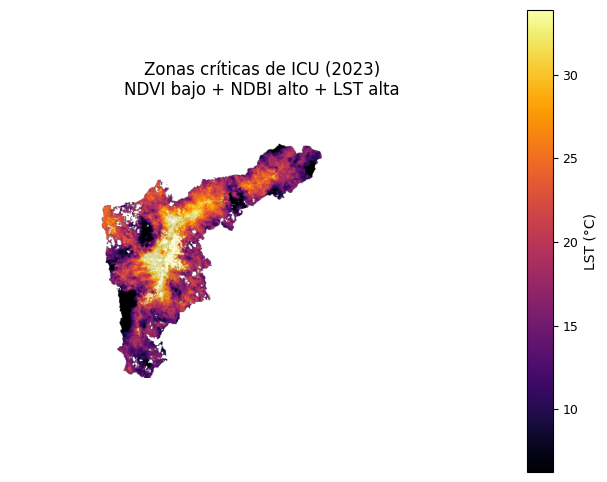

Figura guardada en: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/mapa_zonas_criticas_2023.png


In [59]:
from matplotlib.colors import TwoSlopeNorm
import matplotlib.gridspec as gridspec


transform = src_ndvi.transform
nrows, ncols = ndvi.shape
xmin = transform[2]
xmax = xmin + transform[0] * ncols
ymax = transform[5]
ymin = ymax + transform[4] * nrows
extent = (xmin, xmax, ymin, ymax)


vmin = np.nanpercentile(lst_valid, 5)
vmax = np.nanpercentile(lst_valid, 95)

fig = plt.figure(figsize=(7, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)

ax  = fig.add_subplot(gs[0, 0])
cax = fig.add_subplot(gs[0, 1])


im = ax.imshow(
    lst,
    cmap="inferno",
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    origin="upper"
)


ax.imshow(
    np.ma.masked_where(zonas_criticas == 0, zonas_criticas),
    cmap="Reds",
    alpha=0.6,
    extent=extent,
    origin="upper"
)

ax.set_axis_off()
ax.set_title(
    "Zonas críticas de ICU (2023)\n"
    "NDVI bajo + NDBI alto + LST alta",
    fontsize=12
)

cb = fig.colorbar(im, cax=cax)
cb.set_label("LST (°C)", fontsize=10)
cb.ax.tick_params(labelsize=9)

plt.tight_layout()
out_png = f"{base_sat}/mapa_zonas_criticas_2023.png"
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()

print("Figura guardada en:", out_png)
